This notebook will briefly present _Bayesian spam filtering_, which is an established and effective technique for spam filtering.  The basic idea is to look at documents as _bags of words_ (that is, as mappings of words to frequencies, disregarding ordering).  The underlying assumption is that spam and legitimate documents will have different distributions of words, and that we'll be able to rate the probability that a given set of words came from a legitimate document or a spam document. 



In [1]:
import pandas as pd
import numpy as np
data = pd.read_parquet("data/training.parquet")

We'll start by splitting our data into randomly-selected train and test sets.

In [2]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data)

In [3]:
from sklearn.feature_extraction import text as text_feature

hv = text_feature.HashingVectorizer(norm='l1', alternate_sign=False)
hashed_features = hv.transform(train.text.values)

In [4]:
from sklearn import naive_bayes

nb = naive_bayes.MultinomialNB()
nb.fit(hashed_features, train.label.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [5]:
nb.score(hashed_features, train.label.values)

0.9756333333333334

In [6]:
test_features = hv.transform(test.text.values)
nb.score(test_features, test.label.values)

0.9792

In [24]:
import numpy as np
from sklearn import metrics
labels = ["legitimate", "spam"]
cm = metrics.confusion_matrix(test.label.values, nb.predict(test_features), labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
def labelizer(labels):
    def labelize(tup):
        i, v = tup
        return {'predicted' : labels[int(i / 2)], 'actual' : labels[i & 1], 'value' : v}
    return labelize

labelize = labelizer(labels)

cmdf = pd.DataFrame([labelize(t) for t in enumerate(cm.ravel())])

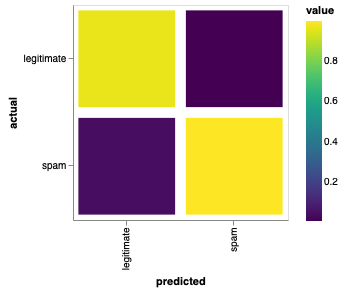

In [35]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(cmdf).mark_rect().encode(
    x='predicted:O',
    y='actual:O',
    color='value:Q'
).properties(width=215, height=215)